In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dropout, Flatten, Bidirectional
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import time
import os

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Mecab을 위한 사전 작업
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 60 (delta 23), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [3]:
cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [4]:
! bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 13.2MB/s 
     |████████████████████████████████| 3.8MB 66.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2020-09-17 02:09:28--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 18.205.93.2, 18.205.93.1, 18.205.93.0, ...
Connecting to bitbucket.org (bitbucket.org)|18.205.93.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?

In [5]:
import pandas as pd
import numpy as np
# from konlpy.tag import Okt
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split

news_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/label_comments.csv", encoding='utf-8')

# 리뷰 데이터 목록
print(news_data)

       label                                               text
0         정상                                         너도 파면 될꺼다.
1         정상  천와대 뒷길에 몇칠째 철야 농성하는 사람들이 이구동성으로 하야하라 외치는데 그건 안...
2         정상                          정신차려요!! 대통령 기냥 적당히 하지말고!!
3         정상         국민들이 뭘 원하는지 진정 안 들리시나요??!! 맨날 소통 타령하더니....
4         정상  해결방안 알려준다.1. 조국사퇴 ,국민사과 후 형사처벌, 관련자 전부 다 처벌2. ...
...      ...                                                ...
205978    혐오  민주당과 청와대가 자위하는 소리...> 10만명을 200만명이라고 해도 대깨문들은 ...
205979    혐오  나도 그날 교대역에서 내리고 타고 했는데 촛불집회 안갔거든? 이새끼들 뻥치는거 하고...
205980    혐오                                      빨갱이ㅅㄲ들 쪽팔린가보네
205981    혐오  놈현을 단죄하지 못한 아쉬움.. 그 때 부엉바위 안갔으면 좀 더 일찍 좌빨의 생얼 ...
205982    혐오  노무현을 죽인 1등공신은 뇌물처받아서 남편 죽여버린 권양숙과 그 일가이고, 2등공신...

[205983 rows x 2 columns]


In [6]:
# label값 정수화
news_data['label'].replace({'정상':1, '혐오':0}, inplace=True)
print(news_data['label'])

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
205978    0.0
205979    0.0
205980    0.0
205981    0.0
205982    0.0
Name: label, Length: 205983, dtype: float64


In [7]:
# 약 2000개의 중복된 데이터가 있음
print(news_data['text'].nunique())
print(news_data['label'].nunique())

194208
2


In [8]:
# 중복 제거
news_data.drop_duplicates(subset=['text'], inplace=True)

In [9]:
print('중복 제거 후 데이터 수 :',len(news_data['text']))

중복 제거 후 데이터 수 : 194209


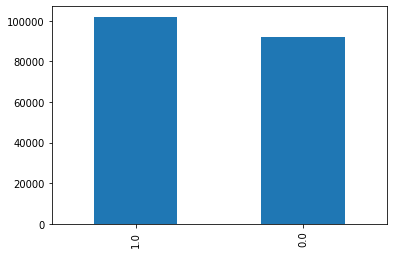

In [10]:
# 데이터가 긍정쪽으로 너무 많이 기울어져 있다.
news_data['label'].value_counts().plot(kind = 'bar')

In [11]:
# 한글과 공백을 제외하고 모두 제거
news_data['text'] = news_data['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
print(news_data)

        label                                               text
0         1.0                                          너도 파면 될꺼다
1         1.0  천와대 뒷길에 몇칠째 철야 농성하는 사람들이 이구동성으로 하야하라 외치는데 그건 안...
2         1.0                              정신차려요 대통령 기냥 적당히 하지말고
3         1.0                 국민들이 뭘 원하는지 진정 안 들리시나요 맨날 소통 타령하더니
4         1.0  해결방안 알려준다 조국사퇴 국민사과 후 형사처벌 관련자 전부 다 처벌 대통령하야 후...
...       ...                                                ...
205978    0.0  민주당과 청와대가 자위하는 소리 만명을 만명이라고 해도 대깨문들은 믿으니까 그렇게 말 해
205979    0.0  나도 그날 교대역에서 내리고 타고 했는데 촛불집회 안갔거든 이새끼들 뻥치는거 하고는...
205980    0.0                                      빨갱이ㅅㄲ들 쪽팔린가보네
205981    0.0  놈현을 단죄하지 못한 아쉬움 그 때 부엉바위 안갔으면 좀 더 일찍 좌빨의 생얼 다 ...
205982    0.0  노무현을 죽인 등공신은 뇌물처받아서 남편 죽여버린 권양숙과 그 일가이고 등공신은 자...

[194209 rows x 2 columns]


In [12]:
# 정규표현식으로 변환 후
# 혹시 공백이 있으면 null array로
news_data['text'] = news_data['text'].replace('', np.nan)
news_data['label'] = news_data['label'].replace('', np.nan)

news_data.isnull().sum()

label      2
text     147
dtype: int64

In [13]:
# 가차없이 지워준다
news_data = news_data.dropna(how='any')
news_data.isnull().sum()

label    0
text     0
dtype: int64

In [14]:
print(news_data)

        label                                               text
0         1.0                                          너도 파면 될꺼다
1         1.0  천와대 뒷길에 몇칠째 철야 농성하는 사람들이 이구동성으로 하야하라 외치는데 그건 안...
2         1.0                              정신차려요 대통령 기냥 적당히 하지말고
3         1.0                 국민들이 뭘 원하는지 진정 안 들리시나요 맨날 소통 타령하더니
4         1.0  해결방안 알려준다 조국사퇴 국민사과 후 형사처벌 관련자 전부 다 처벌 대통령하야 후...
...       ...                                                ...
205978    0.0  민주당과 청와대가 자위하는 소리 만명을 만명이라고 해도 대깨문들은 믿으니까 그렇게 말 해
205979    0.0  나도 그날 교대역에서 내리고 타고 했는데 촛불집회 안갔거든 이새끼들 뻥치는거 하고는...
205980    0.0                                      빨갱이ㅅㄲ들 쪽팔린가보네
205981    0.0  놈현을 단죄하지 못한 아쉬움 그 때 부엉바위 안갔으면 좀 더 일찍 좌빨의 생얼 다 ...
205982    0.0  노무현을 죽인 등공신은 뇌물처받아서 남편 죽여버린 권양숙과 그 일가이고 등공신은 자...

[194061 rows x 2 columns]


In [17]:
# 이제 학습데이터와 테스트 데이터로 나눠준다.
review_train, review_test, y_train, y_test = train_test_split(news_data['text'], news_data['label'], test_size=0.25, shuffle=True)

# # stopwords 지정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# stopwords = ['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', 
#              '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', 
#              '때', '가', '한', '지', '대하', '오', '말', '일', '그렇', 
#              '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', 
#              '못하', '일', '그런', '또', '문제', '더', '많', 
#              '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', 
#              '시키', '만들', '지금', '생각하', '그러', '속', '하나', '살', 
#              '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', 
#              '경우', '명', '다시', '이런', '앞', '보이', '번', '나', '다른', 
#              '어떻', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', 
#              '좀', '원', '잘', '통하', '놓']


# 토큰화 진행

start = time.time()

X_train = []
for stc in review_train:
    token = []
    words = Mecab().morphs(stc)
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_train.append(token)

X_test = []
for stc in review_test:
    token = []
    words = Mecab().morphs(stc)
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_test.append(token)

print("걸린 시간 : ", round((time.time() - start) // 60),"분", round((time.time() - start) % 60),"초")

걸린 시간 :  2 분 44 초


In [18]:
print(X_train[:5])

[['내려오', '세요', '억', '지', '부리', '지', '말', '고'], ['좌파', '탈출', '지능', '순', '친', '북', '탈출', '지식', '순', '문', '빠', '탈출', '지혜', '순', '반미', '탈출', '지성', '순', 'ㅇㅎㅎ', '정말', '웃긴다', '좌파', '비', '의식', '수준', '라고'], ['사업장', '취급', '했', '으면', '세금', '을', '걷', '었', '겠', '지'], ['구구절절', '맞', '말', '니', '가책', '을', '느껴서', '청와대', '게시판', '에서', '없앴', '겠', '지'], ['여기', '달창', 'ㄴ들', '좌표', '찍', '고', '와서', '저것', '인간', '라고', '달창', '대가리', '인', '듯이', '쉴', '드', '치', '거', '진심', '애잔', '하', '다', '달창', '대', '깨', '병진', 'ㅋㅋㅋ']]


In [19]:
# 단어 집합 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'하': 1, '고': 2, '다': 3, '을': 4, '지': 5, '있': 6, '네': 7, '게': 8, '국민': 9, 'ㅋㅋㅋ': 10, '면': 11, '거': 12, '것': 13, '문': 14, '로': 15, '말': 16, '나': 17, '아': 18, '어': 19, '만': 20, '냐': 21, '니': 22, '없': 23, '안': 24, 'ㅋㅋ': 25, '보': 26, '되': 27, '인': 28, '조국': 29, '대통령': 30, '나라': 31, '기': 32, '아니': 33, '겠': 34, '라': 35, '에서': 36, '야': 37, '같': 38, '사람': 39, '해': 40, '했': 41, '재앙': 42, '할': 43, '적': 44, '라고': 45, '는데': 46, '그': 47, '않': 48, '일': 49, '내': 50, '었': 51, '주': 52, '당': 53, '문재인': 54, '알': 55, '대': 56, '수': 57, '더': 58, '시': 59, '정권': 60, '왜': 61, '못': 62, '댓글': 63, '뭐': 64, '진짜': 65, '쓰레기': 66, '이런': 67, '때': 68, '조작': 69, '생각': 70, '시키': 71, '서': 72, '놈': 73, '한다': 74, '까지': 75, '받': 76, '검찰': 77, '민주당': 78, '지금': 79, '해서': 80, '인간': 81, '새끼': 82, '다고': 83, '에게': 84, '좋': 85, '해라': 86, '았': 87, '문제': 88, '너': 89, '으면': 90, '빨갱이': 91, '라는': 92, '이나': 93, '싶': 94, '저': 95, '정부': 96, '던': 97, '글': 98, '좌': 99, '빨': 100, '님': 101, '건': 102, '맞': 103, '조사': 104, '듯': 105, '대한민국': 106,

In [20]:
print(len(tokenizer.word_index))

# 단어 중 등장 빈도가 2 이상인 단어의 개수
wc = 0
for word, word_count in tokenizer.word_counts.items():
    if word_count >= 3:
        wc += 1
print(wc)

55673
26226


In [21]:
# 빈도수가 낮은 단어들을 버리고 유의미하다고 생각되는 남은 단어의 갯수들
tokenizer = Tokenizer(26000, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)

# 설정된 정수 인덱스를 토대로 변환 -> 원핫 인코딩
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [22]:
print(X_train[0:3])
print(tokenizer.word_index)
print(tokenizer.word_counts)
print(len(tokenizer.word_index))

[[1023, 134, 768, 6, 1313, 6, 17, 3], [154, 1362, 1043, 705, 426, 523, 1362, 2364, 705, 15, 116, 1362, 988, 705, 3524, 1362, 6995, 705, 19625, 108, 2352, 154, 371, 1460, 231, 46], [715, 810, 42, 91, 317, 5, 1323, 52, 35, 6]]
{'OOV': 1, '하': 2, '고': 3, '다': 4, '을': 5, '지': 6, '있': 7, '네': 8, '게': 9, '국민': 10, 'ㅋㅋㅋ': 11, '면': 12, '거': 13, '것': 14, '문': 15, '로': 16, '말': 17, '나': 18, '아': 19, '어': 20, '만': 21, '냐': 22, '니': 23, '없': 24, '안': 25, 'ㅋㅋ': 26, '보': 27, '되': 28, '인': 29, '조국': 30, '대통령': 31, '나라': 32, '기': 33, '아니': 34, '겠': 35, '라': 36, '에서': 37, '야': 38, '같': 39, '사람': 40, '해': 41, '했': 42, '재앙': 43, '할': 44, '적': 45, '라고': 46, '는데': 47, '그': 48, '않': 49, '일': 50, '내': 51, '었': 52, '주': 53, '당': 54, '문재인': 55, '알': 56, '대': 57, '수': 58, '더': 59, '시': 60, '정권': 61, '왜': 62, '못': 63, '댓글': 64, '뭐': 65, '진짜': 66, '쓰레기': 67, '이런': 68, '때': 69, '조작': 70, '생각': 71, '시키': 72, '서': 73, '놈': 74, '한다': 75, '까지': 76, '받': 77, '검찰': 78, '민주당': 79, '지금': 80, '해서': 81, '인간': 82, '새끼': 83, 

In [23]:
# 25000 개의 새로운 dict
new_dict = {}

n = 0

for i, v in tokenizer.word_index.items():
  if n == 26000 :
    break
  
  new_dict[i] = v
  n += 1

print(new_dict)
print(len(new_dict))

{'OOV': 1, '하': 2, '고': 3, '다': 4, '을': 5, '지': 6, '있': 7, '네': 8, '게': 9, '국민': 10, 'ㅋㅋㅋ': 11, '면': 12, '거': 13, '것': 14, '문': 15, '로': 16, '말': 17, '나': 18, '아': 19, '어': 20, '만': 21, '냐': 22, '니': 23, '없': 24, '안': 25, 'ㅋㅋ': 26, '보': 27, '되': 28, '인': 29, '조국': 30, '대통령': 31, '나라': 32, '기': 33, '아니': 34, '겠': 35, '라': 36, '에서': 37, '야': 38, '같': 39, '사람': 40, '해': 41, '했': 42, '재앙': 43, '할': 44, '적': 45, '라고': 46, '는데': 47, '그': 48, '않': 49, '일': 50, '내': 51, '었': 52, '주': 53, '당': 54, '문재인': 55, '알': 56, '대': 57, '수': 58, '더': 59, '시': 60, '정권': 61, '왜': 62, '못': 63, '댓글': 64, '뭐': 65, '진짜': 66, '쓰레기': 67, '이런': 68, '때': 69, '조작': 70, '생각': 71, '시키': 72, '서': 73, '놈': 74, '한다': 75, '까지': 76, '받': 77, '검찰': 78, '민주당': 79, '지금': 80, '해서': 81, '인간': 82, '새끼': 83, '다고': 84, '에게': 85, '좋': 86, '해라': 87, '았': 88, '문제': 89, '너': 90, '으면': 91, '빨갱이': 92, '라는': 93, '이나': 94, '싶': 95, '저': 96, '정부': 97, '던': 98, '글': 99, '좌': 100, '빨': 101, '님': 102, '건': 103, '맞': 104, '조사': 105, '듯': 106, 

In [24]:
# 문장 최대 길이
max_length = 0
for data in X_train:
    if max_length < len(data):
        max_length = len(data)
print(max_length)

244


In [ ]:
import json
with open('tokenizer_dict.json','w',encoding='ms949') as f:
    json.dump(new_dict,f, indent=4)

댓글의 최대 길이 : 244
댓글의 평균 길이 : 22.791033700917243


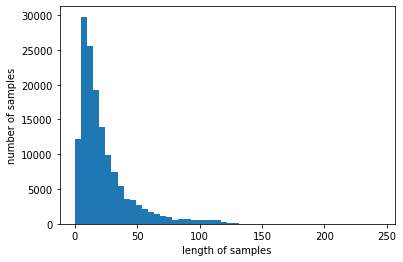

In [25]:
print('댓글의 최대 길이 :',max(len(l) for l in X_train))
print('댓글의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 93.3271496787935


In [27]:
# 문장 길이를 맞춰준다
# 임의로 맞추는게 아니고, 데이터셋을 보면서 최대 문장의 길이가 얼마인지 확인하시고 거기에 맞춰서
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
print(X_train[:3])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0   916  3127     5 19625  2348  1439     4  1254    15    43]
 [   73  3881   205    93   392    16   310    76 10927  3950   109     1
     64    28    22  3279  3212  9772   301    22   253  2667 19626    14
  19626    86   811    14   811    86  8097    46   663     2   384    47
    493   141    14   221   125   289    53   593   113   593 11968   757
     23   441   321   811     5 12568  3374  1536 16240    64   837    22]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     

In [ ]:
# SMOTE 적용
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (136990, 60) (136990,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (259204, 60) (259204,)
SMOTE 적용 후 레이블 값 분포: 
 1    129602
0    129602
dtype: int64


In [32]:
# 레이어들을 쌓을 모델을 생성
model = Sequential()
model.add(Embedding(26000, 64))
model.add(Dropout(0.4))
model.add(Conv1D(64, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

In [33]:
# 혹시 3회 이상 검증데이터 loss가 증가하면, 과적합될 수 있으므로 학습을 조기종료
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
# 훈련을 거듭하면서, 가장 검증데이터 정확도가 높았던 순간을 체크포인트로 저장
model_check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [34]:
# 긍정/부정을 판단하니까 손실함수는 이진 교차 엔트로피, 최적화는 adam, 평가 기준은 acc (출력할때 뜬다)
start = time.time()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stop, model_check])

print("걸린 시간 : ", round((time.time() - start) // 60),"분", round((time.time() - start) % 60),"초")

Epoch 1/10
4549/4549 [==============================] - ETA: 0s - loss: 0.1797 - acc: 0.9329
Epoch 00001: val_acc improved from -inf to 0.95020, saving model to best_model.h5
4549/4549 [==============================] - 68s 15ms/step - loss: 0.1797 - acc: 0.9329 - val_loss: 0.1372 - val_acc: 0.9502
Epoch 2/10
4549/4549 [==============================] - ETA: 0s - loss: 0.1226 - acc: 0.9564
Epoch 00002: val_acc improved from 0.95020 to 0.95261, saving model to best_model.h5
4549/4549 [==============================] - 68s 15ms/step - loss: 0.1226 - acc: 0.9564 - val_loss: 0.1363 - val_acc: 0.9526
Epoch 3/10
4548/4549 [============================>.] - ETA: 0s - loss: 0.1016 - acc: 0.9637
Epoch 00003: val_acc did not improve from 0.95261
4549/4549 [==============================] - 66s 15ms/step - loss: 0.1016 - acc: 0.9637 - val_loss: 0.1398 - val_acc: 0.9514
Epoch 4/10
4546/4549 [============================>.] - ETA: 0s - loss: 0.0861 - acc: 0.9691
Epoch 00004: val_acc did not improve

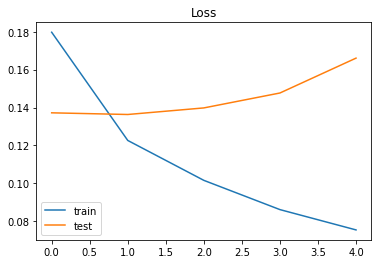

In [37]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

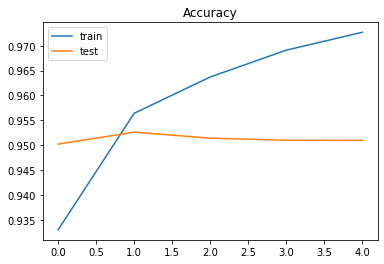

In [38]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [36]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1517/1517 [==============================] - 3s 2ms/step - loss: 0.1363 - acc: 0.9526
테스트 정확도: 0.9526


In [ ]:
print(os.path.dirname(os.path.abspath('best_model.h5')))

/content/Mecab-ko-for-Google-Colab


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

#평가 지표
pred = model.predict(X_test)

pred2 = []
for i in pred:
  if i[0] > 0.5:
    pred2.append([1])
  else:
    pred2.append([0])


print(f'accuracy-score : {accuracy_score(y_test, pred2)}')
print(f'f1-score : {f1_score(y_test, pred2)}')

accuracy-score : 0.9507172891417265
f1-score : 0.9539208695484591


In [ ]:
# 입력값은 전처리, 토큰화, 정수인코딩이 된 상태의 문장
sentence = input()
sentence = sentence.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
token_stc = Mecab().morphs(sentence) # 토큰화
print(token_stc)
sw_pocess_token_stc = [word for word in token_stc if not word in stopwords] # stopword 제거
encode_stc = tokenizer.texts_to_sequences([sw_pocess_token_stc]) # 정수 인코딩
pad_stc = pad_sequences(encode_stc, maxlen=max_len) # 패딩
print(list(pad_stc))
score = loaded_model.predict(pad_stc) # 예측

score = score[0][0]
print(score)

if score > 0.5:
  print(f"{round(score * 100, 2)}% 확률로 긍정의 댓글입니다")
else:
  print(f"{round((1 - score) * 100, 2)}% 확률로 부정의 댓글입니다")